# Profile of `maze_dataset` Dumping and Loading

In [1]:
import os
import itertools
from typing import Callable, Any
import cProfile
import pstats
import copy
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from muutils.statcounter import StatCounter

from maze_dataset.dataset.maze_dataset import (
    MazeDataset,
    MazeDatasetConfig,
)
from maze_dataset.generation.generators import GENERATORS_MAP
from maze_dataset.utils import timeit_fancy, FancyTimeitResult

## Generate Datasets


In [2]:
cfgs: list[MazeDatasetConfig] = [
    MazeDatasetConfig(
		name="test",
		grid_n=grid_n,
		n_mazes=n_mazes,
		maze_ctor=GENERATORS_MAP['gen_dfs'],
	)
    for grid_n, n_mazes in itertools.product(
		[10],
		np.logspace(0, 3, 7, dtype=int).tolist(),
	)
]

datasets: list[MazeDataset] = [MazeDataset.from_config(cfg) for cfg in cfgs]

In [3]:
d = datasets[0]
d.cfg

MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x00000236D0C693A0>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)

In [4]:
d_cpy = copy.deepcopy(d)
d_cpy.cfg

MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x00000236D0C693A0>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)

In [5]:
d_cpy.filter_by.collect_generation_meta()

In [6]:
d_cpy.cfg

MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x00000236D0C693A0>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)

In [7]:
d.cfg

MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x00000236D0C693A0>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)

## Profile

In [8]:
columns: list[str] = ['grid_n', 'n_mazes', 'serialize', 'serialize_minimal', 'load', 'load_minimal', 'save', 'save_minimal', 'read', 'read_minimal']
speeds_data: list[dict] = list()


In [9]:
def wrapped_timeit_fancy(
        name: str,
        function: Callable,
        do_profiling: bool,
        repeats: int,
        timing_stat: Callable[[StatCounter], float],
    ) -> tuple[dict, Any]:
    output: dict = dict()

    result: FancyTimeitResult = timeit_fancy(
        function,
        get_return=True,
        do_profiling=do_profiling,
        repeats=repeats,
    )

    output[name] = timing_stat(result.timings)
    output[f"{name}:stats"] = result.timings
    if do_profiling:
        output[f"{name}:profiling"] = result.profile

    return output, result.return_value



def measure_dataset_speed(
        d: MazeDataset, 
        do_profiling: bool = True,
        repeats: int = 1,
        timing_stat: Callable[[StatCounter], float] = StatCounter.min,
    ) -> dict:
    if repeats > 1:
        warnings.warn("Repeats > 1, results might not be accurate due to generation metadata being collected.")
    kwargs_fancy_timeit: dict = dict(
        do_profiling=do_profiling,
        timing_stat=timing_stat,
        repeats=repeats,
    )
    d.cfg.serialize_minimal_threshold = None
    _d_cpy: MazeDataset = copy.deepcopy(d)
    # set up row data
    row_data: dict = dict(
        grid_n=d.cfg.grid_n,
        n_mazes=d.cfg.n_mazes,
    )
    # serialization & loading
    info_serialize, result_serialize = wrapped_timeit_fancy(
        'serialize', _d_cpy.serialize, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min, result_serialize_min = wrapped_timeit_fancy(
        'serialize_minimal', _d_cpy._serialize_minimal, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min)
    _d_cpy = copy.deepcopy(d)

    info_serialize_min_alt, result_serialize_min_alt = wrapped_timeit_fancy(
        'serialize_minimal_alt', _d_cpy._serialize_minimal_alt, **kwargs_fancy_timeit
    )
    row_data.update(info_serialize_min_alt)
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'load', lambda: MazeDataset.load(result_serialize), **kwargs_fancy_timeit
    )[0])
    row_data.update(wrapped_timeit_fancy(
        'load_minimal', lambda: MazeDataset._load_minimal(result_serialize_min), **kwargs_fancy_timeit
    )[0])
    
    # saving and loading
    path_default: str = f'../data/{d.cfg.to_fname()}.zanj'
    path_min: str = f'../data/{d.cfg.to_fname()}_min.zanj'

    # default
    d.cfg.serialize_minimal_threshold = None
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save', lambda: _d_cpy.save(file_path=path_default), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)

    row_data.update(wrapped_timeit_fancy(
        'read', lambda: MazeDataset.read(file_path=path_default), **kwargs_fancy_timeit
    )[0])

    # minimal
    d.cfg.serialize_minimal_threshold = 0
    _d_cpy = copy.deepcopy(d)
    row_data.update(wrapped_timeit_fancy(
        'save_minimal', lambda: _d_cpy.save(file_path=path_min), **kwargs_fancy_timeit
    )[0])
    _d_cpy = copy.deepcopy(d)
    
    row_data.update(wrapped_timeit_fancy(
        'read_minimal', lambda: MazeDataset.read(file_path=path_min), **kwargs_fancy_timeit
    )[0])

    # asserts
    # assert d == read_default
    # assert d == read_minimal

    # reset cfg?
    d.cfg.serialize_minimal_threshold = None

    return row_data

## Profile small datasets only

In [10]:
for i, d in enumerate(datasets):
    print(f'Profiling {i+1}/{len(datasets)}:\t{d.cfg}')
    result = measure_dataset_speed(d)
    speeds_data.append(result)
    cols_short: str = str({k : v for k,v in result.items() if ':' not in k})
    print(f"\t{cols_short}")
    print(f"\t{str(d.cfg)}")

Profiling 1/7:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x00000236D0C693A0>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
	{'grid_n': 10, 'n_mazes': 1, 'serialize': 0.0024355000350624323, 'serialize_minimal': 0.0026490000309422612, 'serialize_minimal_alt': 0.0021256000036373734, 'load': 0.005637299967929721, 'load_minimal': 0.003675500047393143, 'save': 0.03912820003461093, 'read': 0.03214579995255917, 'save_minimal': 0.024362700060009956, 'read_minimal': 0.009836999932304025}
	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512, seed=42, applied_filters=[{'name': 'collect_generation_meta', 'args': (), 'kwargs': {}}], grid_n=10, n_mazes=1, maze_ctor=<function LatticeMazeGenerators.gen_dfs at 0x00000236D0C693A0>, maze_ctor_kwargs={}, serialize_minimal_threshold=None)
Profiling 2/7:	MazeDatasetConfig(name='test', seq_len_min=1, seq_len_max=512,

### Results

In [11]:
SPEEDS: pd.DataFrame = pd.DataFrame(speeds_data)

def compute_speedups(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> pd.DataFrame:
    for prefix in column_measurement_prefixes:
        speeds[f'{prefix}_speedup'] = speeds[f'{prefix}'] / speeds[f'{prefix}_minimal']
    return speeds

SPEEDS = compute_speedups(SPEEDS)

In [12]:
SPEEDS[[c for c in SPEEDS.columns if ':' not in c]]

,grid_n,n_mazes,serialize,serialize_minimal,serialize_minimal_alt,load,load_minimal,save,read,save_minimal,read_minimal,serialize_speedup,load_speedup,save_speedup,read_speedup
0,10,1,0.002436,0.002649,0.002126,0.005637,0.003676,0.039128,0.032146,0.024363,0.009837,0.919404,1.533750,1.606070,3.267846
1,10,3,0.003627,0.002677,0.006612,0.009387,0.003152,0.024467,0.032576,0.022077,0.019173,1.354536,2.977731,1.108276,1.699058
2,10,10,0.006677,0.005804,0.005145,0.030607,0.003784,0.068044,0.030918,0.017908,0.009748,1.150374,8.089199,3.799600,3.171825
3,10,31,0.002174,0.013881,0.007146,0.067015,0.003614,0.090204,0.075587,0.022659,0.010530,0.156599,18.541002,3.980878,7.178563
4,10,100,0.002759,0.028009,0.022647,0.231195,0.004602,0.343798,0.260396,0.025386,0.012705,0.098513,50.234665,13.542762,20.495238
5,10,316,0.003768,0.059358,0.049483,0.835659,0.008064,0.262554,0.889173,0.044327,0.021798,0.063475,103.621874,5.923159,40.790755
6,10,1000,0.008064,0.160352,0.132968,2.763654,0.021858,0.912412,2.193961,0.134798,0.033949,0.050287,126.439024,6.768730,64.625955


Plotting serialize timings and speedups
Plotting grid_n=10
Plotting load timings and speedups
Plotting grid_n=10
Plotting save timings and speedups
Plotting grid_n=10
Plotting read timings and speedups
Plotting grid_n=10


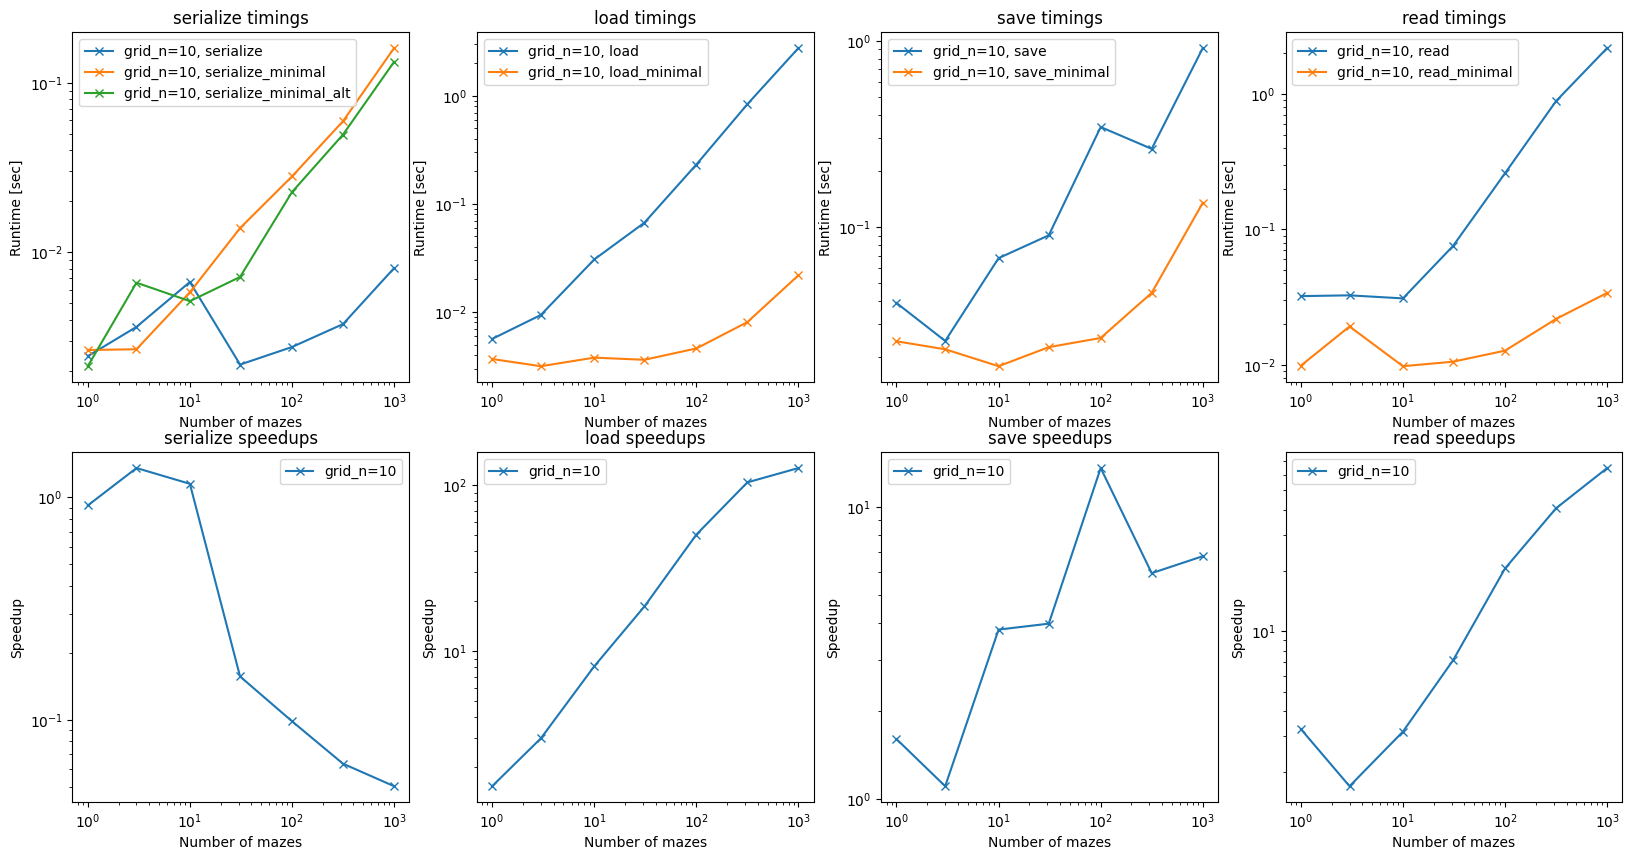

In [13]:
def plot_speeds(speeds: pd.DataFrame, column_measurement_prefixes: list[str] = ['serialize', 'load', 'save', 'read']) -> None:
    n_measurements: int = len(column_measurement_prefixes)
    fig, axs = plt.subplots(2, n_measurements, figsize=(n_measurements*5, 10))

    unique_grid_ns: list[int] = speeds['grid_n'].unique().tolist()

    for i, prefix in enumerate(column_measurement_prefixes):
        print(f'Plotting {prefix} timings and speedups')
        for grid_n in unique_grid_ns:
            print(f'Plotting grid_n={grid_n}')
            # raw timings
            ax_timings = axs[0, i]
            speeds_masked = speeds[speeds['grid_n'] == grid_n].sort_values('n_mazes')
            x_n_mazes = speeds_masked['n_mazes']

            # Plotting
            ax_timings.plot(x_n_mazes, speeds_masked[f'{prefix}'], "x-", label=f'grid_n={grid_n}, {prefix}')
            ax_timings.plot(x_n_mazes, speeds_masked[f'{prefix}_minimal'], "x-", label=f'grid_n={grid_n}, {prefix}_minimal')

            _alt = f'{prefix}_minimal_alt'
            if _alt in speeds.columns:
                ax_timings.plot(x_n_mazes, speeds_masked[_alt], "x-", label=f'grid_n={grid_n}, {_alt}')

            # Setting multiple properties with `set`
            ax_timings.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Runtime [sec]', title=f'{prefix} timings')
            ax_timings.legend()

            # speedups
            ax_speedups = axs[1, i]
            ax_speedups.plot(x_n_mazes, speeds_masked[f'{prefix}_speedup'], "x-", label=f'grid_n={grid_n}')

            # Setting multiple properties with `set` for ax_speedups
            ax_speedups.set(xscale='log', yscale='log', xlabel='Number of mazes', ylabel='Speedup', title=f'{prefix} speedups')
            ax_speedups.legend()


plot_speeds(SPEEDS)


Comparing rows 2 and 4, it appears that the `grid_n` has a relatively small effect on `serialize` and `load` runtimes. Those functions appear to run in $O(n_{\mathrm{mazes}})$ time. `grid_n` does impact `save` and `read`, but not their `_minimal` counterparts as much.

To compare the speed of analogous procedures vs `n_mazes`, the plots below show data from `speeds.loc[3:,:]`.

In [14]:
SPEEDS[['grid_n', 'n_mazes', 'serialize_minimal_alt:profiling']]

,grid_n,n_mazes,serialize_minimal_alt:profiling
0,10,1,<pstats.Stats object at 0x00000236D1D11210>
1,10,3,<pstats.Stats object at 0x00000236D1F0A6D0>
2,10,10,<pstats.Stats object at 0x00000236D210C5D0>
3,10,31,<pstats.Stats object at 0x00000236D2257B90>
4,10,100,<pstats.Stats object at 0x00000236D1E074D0>
5,10,316,<pstats.Stats object at 0x00000236D2454D10>
6,10,1000,<pstats.Stats object at 0x00000236D2E91190>


In [15]:
SPEEDS['serialize_minimal_alt:profiling'][6].sort_stats('cumulative').print_stats(10)

         11049 function calls (10824 primitive calls) in 0.009 seconds

   Ordered by: cumulative time
   List reduced from 84 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.003    0.003    0.009    0.009 maze_dataset.py:380(_serialize_minimal_alt)
        2    0.000    0.000    0.004    0.002 json_serialize.py:271(json_serialize)
    195/2    0.000    0.000    0.004    0.002 json_serialize.py:231(json_serialize)
        1    0.000    0.000    0.004    0.004 json_serialize.py:124(_serialize_override_serialize_func)
        1    0.000    0.000    0.004    0.004 serializable_dataclass.py:356(serialize)
        1    0.000    0.000    0.004    0.004 maze_dataset.py:62(<lambda>)
        1    0.000    0.000    0.004    0.004 util.py:122(safe_getsource)
        1    0.000    0.000    0.004    0.004 inspect.py:1256(getsource)
        1    0.000    0.000    0.004    0.004 inspect.py:1235(getsourcelines)
        1    0.000   